### Including necessary libs:

In [86]:
import matplotlib.pyplot as plt
import numpy as np
import math
from numpy.linalg import inv
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# To plot pretty figures
import matplotlib

import matplotlib.pyplot as plt

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

%matplotlib inline

from sklearn.metrics import confusion_matrix,classification_report

np.random.seed(42)

Importing data:

In [87]:
X=np.array([(4,1940),(9,2960),(9,4630),(78,1528),(90,2040),(50,3700),(467,14815),(509,15200),(290,15700),(215,6045)])

x1 = np.array(X[:,0])
x2 = np.array(X[:,1])

train_data = np.array(X)
max_values = train_data.max(0)

X_norm = np.divide(train_data,max_values)


data_set=X_norm
groups = 2
space=[[0,1],[0,1]]

error_margin = 0.01
m = 2.0

assignation=np.zeros((len(X),groups))

import random

centers = []

pdm = []

def select_centers():
    global centers
    global groups
    global space
    iter=0
    while iter<groups:
        centers.append((random.uniform(space[0][0],space[0][1]), 
                        random.uniform(space[1][0],space[1][1])))
        iter=iter+1
        
select_centers()

Covariance matrix:

In [88]:
cx1 = np.array(X_norm[:,0])

cx2 = np.array(X_norm[:,1])

R = np.cov(cx1, cx2)

print(R)

invR = inv(R)

[[0.1407423  0.1289333 ]
 [0.1289333  0.14320383]]


## Possibilistic k-means (PCM) 

First, we need to implement the Mahalanobis distance function:

In [89]:
def mahalanobis_distance(x,v):
    return math.sqrt( ((x - v).dot(invR)).dot( (x-v).T ) )

To calculate possibilistic distribution measure, a starting u is necessary:

In [90]:
def calculate_entry_u(x,i):
    global centers
    if i == 0:
        sum = 1.0 + ( mahalanobis_distance(x, centers[0])/mahalanobis_distance(x, centers[1]) )**2
    else:
        sum = 1.0 + ( mahalanobis_distance(x, centers[1])/mahalanobis_distance(x, centers[0]) )**2
    return sum**-1

global centers

global entry_u

entry_u = []

for i in range(len(data_set)):
    entry_u_vector = []
    for k in range(groups):
        entry_u_vector.append(calculate_entry_u(data_set[i],k))
    entry_u.append(entry_u_vector)       

Update of centers is also necessary:

In [91]:
calculate_new_centers( entry_u )

assignation = entry_u

Posibilistic distibution measure:

In [92]:
def calc_pdm(x,u):
    global pdm
    global centers
    new_pdm = []
    for c in range(groups):
        u_scalar = 0.0
        u_scalar_2 = 0.0
        for i in range(len(data_set)):
            u_scalar = u_scalar + ( u[i][c]**m )*( mahalanobis_distance(x, centers[c]))**2
            u_scalar_2 = u_scalar_2 + ( u[i][c]**m )
        new_pdm.append(np.divide(u_scalar, u_scalar_2))
    pdm = new_pdm
    return pdm

The next step is to calculate the new assignation matrix:

In [93]:
def calculate_u(x,i):
    global centers
    uik = []
    if i == 0:
        uik = 1.0 + ( mahalanobis_distance(x, centers[0])/calc_pdm(x,entry_u)[1] )**2 
    else:
        uik = 1.0 + ( mahalanobis_distance(x, centers[1])/calc_pdm(x,entry_u)[0] )**2
    return uik**-1

After this, new centers has to be calculated: 

In [94]:
def calculate_new_centers(u):
    global centers
    new_centers = []
    for c in range(groups):
        u_x_vector = np.zeros(2)
        u_scalar = 0.0
        for i in range(len(data_set)):
            u_scalar = u_scalar+(u[i][c]**m)
            u_x_vector = np.add( u_x_vector,np.multiply(u[i][c]**m,data_set[i]) )
        new_centers.append( np.divide(u_x_vector,u_scalar) )
    centers=new_centers

Set the rule to stop the loop:

In [95]:
def calculate_differences(new_assignation):
    global assignation    
    return np.sum(np.abs(np.subtract(assignation,new_assignation)))

All together:

In [96]:
def cluster():
    global assignation    
    global error_margin    
    global groups
    difference_limit_not_achieved=True
    iter=0
    while difference_limit_not_achieved:
        new_assignation=[]
        for i in range(len(data_set)):
            new_assignation_vector=[]
            for k in range(groups):
                new_assignation_vector.append(calculate_u(data_set[i],k))
            new_assignation.append(new_assignation_vector)
        calculate_new_centers(new_assignation)

        if iter>0:
            if calculate_differences(new_assignation) < error_margin:
                difference_limit_not_achieved=False
        assignation=new_assignation
        iter=iter+1

Testing:

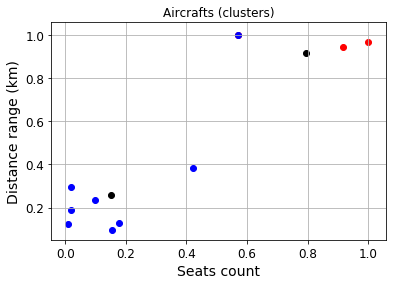

In [97]:
cluster()

red = X_norm[np.where(np.array(assignation)[:,0] > 0.5)]

blue = X_norm[np.where(np.array(assignation)[:,1] > 0.5)]

fig, ax = plt.subplots()

ax.scatter(blue[:,0],blue[:,1],c='red')

ax.scatter(red[:,0],red[:,1],c='blue')

ax.scatter(np.array(centers)[:,0],np.array(centers)[:,1],c='black')

ax.set(xlabel='Seats count', ylabel='Distance range (km)',
       title='Aircrafts (clusters)')

ax.grid()

plt.show()

To calculate Czekanowski-Dice index, it is required to assign groups according to the assignation matrix.

In [98]:
def assign_groups(assignation):
    assigned_groups = []
    for el in range(len(assignation)):
        group_id = np.argmax(assignation[el])
        assigned_groups.append(group_id)
    return assigned_groups

In [99]:
assigned_groups = assign_groups(assignation)

Confusion matrix also requires - next to prediction, which in this case is assigned groups - test data. Since the data set has none, labels are set manually:

In [100]:
labels = np.array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1])

Having all the data ready, confusion matrix can be calculated:

[[3 2]
 [4 1]]


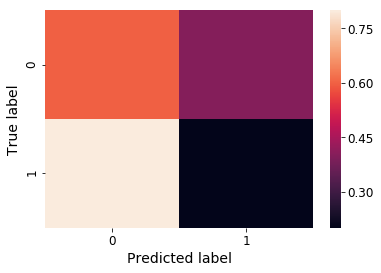

In [101]:
conf_mat = confusion_matrix(labels, assigned_groups)

conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

sns.heatmap(conf_mat_normalized)

plt.ylabel('True label')

plt.xlabel('Predicted label')

print(conf_mat)

From confusion matrix, it is now possible to calculate precision and recall scores:

In [102]:
precision_score = (conf_mat[1][1] / ( conf_mat[1][1] + conf_mat[0][1] ))

recall_score = (conf_mat[1][1] / ( conf_mat[1][1] + conf_mat[1][0] ))

print("Recall = ", recall_score)

print("Precision = ",precision_score)

Recall =  0.2
Precision =  0.3333333333333333


With Precision and Recall scores calculated, Czekanowski index is defined according to the formula:

\begin{equation}
C=2\frac{P\times R}{P+R}.
\end{equation}

In [103]:
def czekanowski_index(P, R):
    C_c = np.multiply(P,R)
    C_d = np.add(P, R)
    C = np.divide(C_c, C_d)
    return 2*C

And the final result:

In [104]:
print(czekanowski_index(precision_score, recall_score))

0.25


Although the data set was simple - two groups, only 10 elements in the data set - and the  test data was "random", the final results present the proper calculation of Czekanowski-Dice index for clustering, which can easily be adapted to more complicated clustering problems.